In [3]:
from utils.utils import get_data_frame, get_data_frame_for_symbols
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import getopt
import sys
import datetime
from matplotlib.finance import candlestick_ohlc, candlestick2_ochl, candlestick2_ohlc

In [194]:
def bollinger_bands(rolling_mean, rolling_std):
    upper_band = rolling_mean + rolling_std * 2
    lower_band = rolling_mean - rolling_std * 2

    return upper_band, lower_band

In [195]:
def rolling_std(data_col, window=20):
    return data_col.rolling(window, center=False).std()

def rolling_mean(data_col, window=20):
    return data_col.rolling(window, center=False).mean()

In [196]:
def plot_bollinger_band(data_col, symbol, window = 20):    
    ax = data_col.plot(title='Bollinger bands de ' + str(symbol) + ' avec window = ' + str(window) , label=symbol)

    rm = rolling_mean(data_col, window = window)
    rm.plot(label='Rolling mean', ax=ax)

    rstd = rolling_std(data_col, window = window)

    upper_band, lower_band = bollinger_bands(rm, rstd)

    upper_band.plot(label='Upper band', ax=ax, figsize= (15, 8))
    lower_band.plot(label='Lower band', ax=ax, figsize= (15, 8))

    plt.legend(loc='upper left')
    plt.show()


In [241]:
def candlestick(data, stick  = "day", otherseries = None):
    """
    stick in ["day","week","month","year"] or int if number of dates to group by
    data: index -> type: datetime
          columns = ["Open","High","Low","Close", "Adj Close]
    tips convert str to date
    spy.Date = spy.Date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
    """
    %pylab inline
    pylab.rcParams['figure.figsize'] = (15, 8)   # Change the size of plots
    
    from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
    from matplotlib.dates import date2num
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    dayFormatter = DateFormatter('%d')  
    
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdata = data.loc[:,["Open","High","Low","Close"]]
    if (type(stick)== str):
        if stick == "day":
            plotdata = transdata
            stick = 1 
        elif stick in ["week","month","year"]:
            if stick == "week":
                transdata["week"] = pd.to_datetime(transdata.index).map(lambda x: x.isocalendar()[1])#identify weeks
                transdata["year"] = pd.to_datetime(transdata.index).map(lambda x: x.isocalendar()[0])
            elif stick == "month":
                transdata["month"] = pd.to_datetime(transdata.index).map(lambda x: x.month) # Identify months
                transdata["year"] = pd.to_datetime(transdata.index).map(lambda x: x.isocalendar()[0])
            else:
                transdata["year"] = pd.to_datetime(transdata.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdata.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdata = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            
            for name, group in grouped:
                plotdata = plotdata.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
    elif (type(stick) == int and stick >= 1):
        transdata["stick"] = [np.floor(i / stick) for i in range(len(transdata.index))]
        grouped = transdata.groupby("stick")
        plotdata = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdata = plotdata.append(pd.DataFrame({"Open": group.iloc[0,0],
                                                     "High": max(group.High),
                                                     "Low": min(group.Low),
                                                     "Close": group.iloc[-1,3]},
                                                     index = [group.index[0]]))
            
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
        
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdata.index[-1] - plotdata.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%d-%m-%Y')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
    
    ax.grid(True)
    
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdata.index.tolist())), plotdata["Open"].tolist(), plotdata["High"].tolist(),
                      plotdata["Low"].tolist(), plotdata["Close"].tolist())),
                      colorup = "green", colordown = "red", width = stick * .4)
    
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        data.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

In [242]:
start_date = '2017-01-01'
end_date = '2017-09-01'
symbol = 'SPY'
window = 20

In [248]:
spy = pd.read_csv("data/AAPL.csv", sep = ",")

In [249]:
spy.Date = spy.Date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [250]:
spy.set_index("Date", inplace= True)

Populating the interactive namespace from numpy and matplotlib


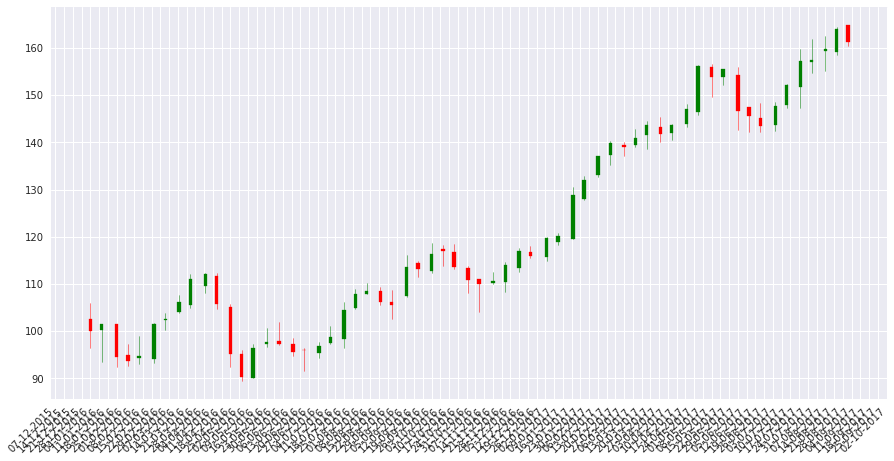

In [252]:
candlestick(spy, stick= 7)

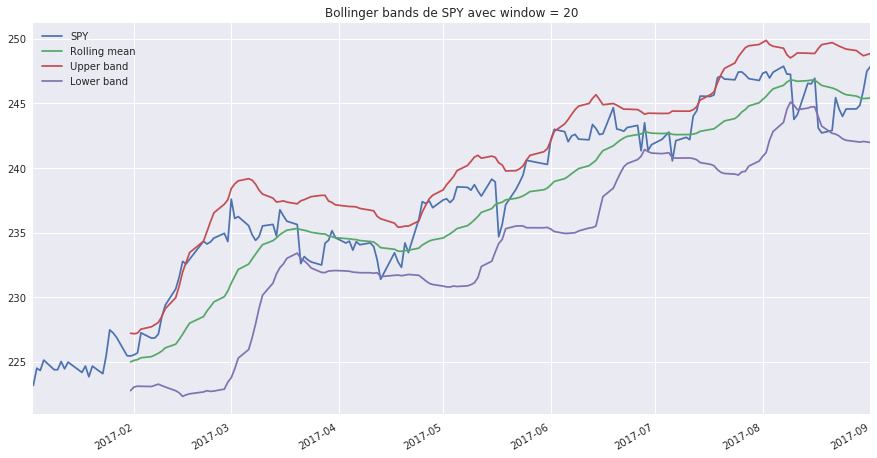

In [89]:
data_frame = get_data_frame(symbol, start_date, end_date, dropna=True)
data_col = data_frame[symbol]
plot_bollinger_band(data_col, symbol, 20)